In [32]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function
import torch.utils.data as data
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from itertools import product as product
from math import sqrt as sqrt

In [2]:
def make_vgg():
    layers = []
    in_channels = 2  # 色チャネル数
    #なぜか自分で実装している
    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
#     cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
#            256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

#     for v in cfg:
#         if v == 'M':
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#         elif v == 'MC':
#             # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
#             # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
#         else:
#             conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
#             layers += [conv2d, nn.ReLU(inplace=True)]
#             in_channels = v

#     pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
#     conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
#     conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    Conv2_1 = nn.Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    Conv2_3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    Conv2_5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_6 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_7 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Maxpool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    Conv2_8 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_9 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_10 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Maxpool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    Conv2_11 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_12 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Conv2_13 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Maxpool_5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    Conv2_14 = nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
    Conv2_15 = nn.Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    
    
    layers += [Conv2_1, nn.ReLU(inplace=True), Conv2_2, nn.ReLU(inplace=True), Maxpool_1, Conv2_3, nn.ReLU(inplace=True), Conv2_4, nn.ReLU(inplace=True), Maxpool_2, Conv2_5, nn.ReLU(inplace=True), Conv2_6, nn.ReLU(inplace=True), Conv2_7, nn.ReLU(inplace=True), Maxpool_3, Conv2_8, nn.ReLU(inplace=True), Conv2_9, nn.ReLU(inplace=True), Conv2_10, nn.ReLU(inplace=True), Maxpool_4, Conv2_11, nn.ReLU(inplace=True), Conv2_12, nn.ReLU(inplace=True), Conv2_13, nn.ReLU(inplace=True), Maxpool_5, Conv2_14, nn.ReLU(inplace=True), Conv2_15, nn.ReLU(inplace=True)]
    
    return nn.ModuleList(layers)

# 8層にわたる、extrasモジュールを作成
def make_extras():
    layers = []
    in_channels = 1024  # vggモジュールから出力された、extraに入力される画像チャネル数

    # extraモジュールの畳み込み層のチャネル数を設定するコンフィギュレーション
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))] # 0
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]  # #1
#     layers += [nn.MaxPool2d(kernel_size=2)]  #Maxpoolは自分で付け足した   #2
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))] #2
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]  #  #3
#     layers += [nn.MaxPool2d(kernel_size=2)]  #Maxpoolは自分で付け足した #5 
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]  #4
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]  #5
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]  #6
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]  #7

    return nn.ModuleList(layers)


In [25]:
x = np.load('../data_for_ssd/Churchwell_data/center_ring_data/std/CN 100.npy')
print(x.shape)
x = x[:2, :, :]
x.shape

(3, 300, 300)


(2, 300, 300)

In [26]:
x = torch.tensor(x, dtype=torch.float)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 2, 300, 300])

In [27]:
vgg = make_vgg()

In [28]:
for k in range(23):
    x = vgg[k](x)

In [29]:
x.shape

torch.Size([1, 512, 38, 38])

In [38]:
s = x
s = s.squeeze(0)
s = s.detach().numpy()
s = np.sum(s, axis=0)

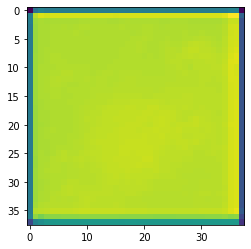

In [39]:
plt.imshow(s)

In [40]:
s

array([[2.06752  , 2.119823 , 2.128601 , ..., 2.1292303, 2.1279614,
        2.0700138],
       [2.126636 , 2.190288 , 2.197123 , ..., 2.2048044, 2.2050636,
        2.111743 ],
       [2.1259477, 2.1849947, 2.1877012, ..., 2.1935172, 2.1937008,
        2.1024234],
       ...,
       [2.1248832, 2.1891832, 2.191093 , ..., 2.1970181, 2.2002141,
        2.1076505],
       [2.1278806, 2.1820333, 2.1770382, ..., 2.1807635, 2.1816413,
        2.097154 ],
       [2.0972354, 2.1290324, 2.1357284, ..., 2.1421075, 2.1421733,
        2.0885355]], dtype=float32)